# <font color=blue>OPTIM/OPTECH Laboratory Learning Session IV: </font> 
## <font color=blue>METAHEURISTIC ALGORITHMS</font> 

### `MASTEAM`: Master's degree in Applied Telecommunications and Engineering Management
### `MATT`: Master's degree in Advanced Telecommunication Technologies
### `CoDaS`: Erasmus Mundus master's degree in Communications, Engineering and Data Science

#####  Castelldefels School of Telecommunications and Aerospace Engineering (EETAC)

**<font color=teal>Cristina Cervelló-Pastor (cristina.cervello@upc.edu)</font>**

## <font color=green><b>GENETIC ALGORITHM</b></font>

<b><font color=blue>Genetic algorithms</font></b> are evolutionary algorithms well suited to searching global solutions to the varied nature of optimization problems. The inspirations in developing GA are derived from the working principle of natural genetics. The operators such as reproduction, crossover & mutation are employed similarly to natural genetics.

A GA searches through a space of "chromosomes," each representing a candidate solution to a given problem (in some cases, a solution consists of a set of chromosomes). Most methods called GAs have at least the following elements in common: populations of chromosomes, selection according to ﬁtness, crossover to produce new offspring (child), and random mutation of new offspring. The chromosomes in a GA population most often take the form of bit strings (i.e., strings of 1s and 0s); each bit position ("locus") in the chromosome has two possible values ("alleles" ): 0 and 1.

In this laboratory, we will apply GA to find a solution to the <b><font color=blue>traveling salesman problem (TSP)</font></b>. In the TSP problem, given a list of network nodes, knowing the distance between each pair of nodes, obtain the shortest possible route that passes through each node and returns to the origin node. Thus, the constraints are:

<ol> 
<li> Each node needs to be visited exactly one time
<li> The path must return to the starting node
</ol>

In this scenario, the elements are the following:

<ul> 
<li> <b><font color=blue>Gene</font></b>: a node represented as (x, y) coordinates
    
<li> <b><font color=blue>Individual or chromosome</font></b>: a single route satisfying the conditions of the TSP
    
<li> <b><font color=blue>Population</font></b>: a set of possible routes
    
<li> <b><font color=blue>Fitness</font></b>: a function to calculate how good each route is
    
<li> <b><font color=blue>Mating pool</font></b>: a collection of individuals that are used to create the next population (thus creating the next generation of routes)
    
<li> <b><font color=blue>Crossover</font></b>: a function to combine two parents (two routes) to create a new route
    
<li> <b><font color=blue>Mutation</font></b>: a function to modify one route by randomly swap two nodes of it
    
<li> <b><font color=blue>Elitism</font></b>: a criterion to carry the best individuals into the next generation (directly, without crossing or mutating)
</ul>

In [490]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

## <font color=purple>Python functions</font>

In [491]:
""" Compute the distance between two nodes """

def Distance(node1, node2):
    
    xDis = abs(nodeList[node1]['x'] - nodeList[node2]['x'])
    yDis = abs(nodeList[node1]['y'] - nodeList[node2]['y'])
    distance = np.sqrt((xDis ** 2) + (yDis ** 2))
    
    return distance

In [492]:
""" Compute the total distance of one path """

def RouteDistance(route):
    
    pathDistance = 0
    for i in range(0, len(route)):
        fromNode = route[i]
        toNode = None
        if i+1 < len(route):
            toNode = route[i+1]
        else:
            toNode = route[0]
        pathDistance += Distance(fromNode, toNode)
    
    return pathDistance

In [493]:
""" Due to we are searching for the shortest path, the fitness is the inverse of the route distance'
    'multiplied by 1000 to get greater numbers """

def RouteFitness(route):
    
    fitness = 1000.0 / float(RouteDistance(route))
    
    return fitness

In [494]:
""" Create a route randomly """ 

def CreateRoute(nodeList):
    
    route = random.sample(list(nodeList.keys()), len(nodeList))
    
    return route

In [495]:
""" Initiate the population """

def InitialPopulation(nodeList, popSize):
    
    population = [{} for i in range(popSize)]
    for i in range(0, popSize):
        # The route is randomly generated'
        route = CreateRoute(nodeList)
        # Each individual of the population has information about the path, distance and fitness
        population[i]['path'] = route
        population[i]['distance'] = RouteDistance(route)
        population[i]['pathFitness'] = RouteFitness(route)
        
    return population

In [496]:
""" Rank routes in function of the path fitness """ 

def ClassifyRoutes(population):
    
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = population[i]['pathFitness']
    
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [497]:
""" Select a list of individuals based on fitness and applying elitism """ 

def Selection(popClassified, eliteSize):
    
    selectionResults = []
    # Generate a data frame with the different routes and their fitness
    df = pd.DataFrame(np.array(popClassified), columns=["Index","Fitness"])
    # Cumulative sum of the fitness
    df['cum_sum'] = df.Fitness.cumsum()
    # Cumulative percentage of the fitness
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    # The best 'eliteSize' individuals are directly selected
    for i in range(0, eliteSize):
        selectionResults.append(popClassified[i][0])
        
    # The rest are selected randomly taking into account the cumulative percentage
    for i in range(0, len(popClassified) - eliteSize):
        ran = 100*random.random()
        for i in range(0, len(popClassified)):
            # df.iat gets a value at specified row/column pair
            if ran <= df.iat[i,3]:
                'if random number is lower than the cumulative percentage'
                'of the individual fitness, it is selected'
                selectionResults.append(popClassified[i][0])
                break
    
    return selectionResults

In [498]:
""" Create the mating pool from the selected list of individuals """ 

def MatingPool(population, selectionResults):
    
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
        
    return matingpool

In [499]:
""" Cross two parents to get a child with probability crossoverProb """ 

def Crossover(parent1, parent2, crossoverProb):
    
    if(random.random() < crossoverProb):
        child = []
        childP1 = []
        childP2 = []

        # Get two nodes of the parent1
        geneA = int(random.random() * len(parent1))
        geneB = int(random.random() * len(parent1))

        # Order the selected nodes
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)

        # Get the first nodes (genes) of the parent1
        for i in range(startGene, endGene):
            childP1.append(parent1[i])

        # Fill the rest of the route with the nodes (genes) from the parent2 without repeating any node
        childP2 = [item for item in parent2 if item not in childP1]

        # The final child will be part of parent1 and part of parent2
        child = childP1 + childP2
    else:
        child = parent1
    
    return child

In [500]:
""" Cross all the individuals of the population parents to get the children (set of new individuals) """ 

def CrossoverPopulation(matingpool, eliteSize, crossoverProb):
    
    children = []
    
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    
    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child={}
        route = Crossover(pool[i]['path'], pool[len(matingpool)-i-1]['path'], crossoverProb)
        
        # Update the information of the individual
        child['path'] = route
        child['distance'] = RouteDistance(route)
        child['pathFitness'] = RouteFitness(route)
        
        # Add the individual to the new population
        children.append(child)
        
    return children

In [501]:
""" Swap two nodes of one individual with probability mutationProb """ 

def Mutate(individual, mutationProb):
    
    for swap1 in range(len(individual['path'])):
        if(random.random() < mutationProb):
            swap2 = int(random.random() * len(individual))

            node1 = individual['path'][swap1]
            node2 = individual['path'][swap2]
            
            individual['path'][swap1] = node2
            individual['path'][swap2] = node1
            
            # Update the information of the individual
            individual['distance'] = RouteDistance(individual['path'])
            individual['pathFitness'] = RouteFitness(individual['path'])
            
    return individual

In [502]:
""" Mutate all the individuals of the population with a mutation probability """ 

def MutatePopulation(population, mutationProb):

    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = Mutate(population[ind], mutationProb)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [503]:
""" Get the next generation from the current one """ 

def NextGeneration(currentGen, eliteSize, crossoverProb, mutationProb):
    
    # Population ordered according the fitness
    populationRanked = ClassifyRoutes(currentGen)
    
    # Select the list of the best individuals based on their fitness and applying elitism
    selectionList = Selection(populationRanked, eliteSize)
    
    # Create the mating pool from the selected list of individuals
    matingpool = MatingPool(currentGen, selectionList)
    
    # Get the children crossing the parents with certain probability
    children = CrossoverPopulation(matingpool, eliteSize, crossoverProb)
    
    # Get the next generation mutating the previous children with certain probability
    nextGeneration = MutatePopulation(children, mutationProb)

    return nextGeneration

In [504]:
""" Function to run the GA algorithm plot the evolution of the GA """ 

def GeneticAlgorithm(population, popSize, eliteSize, crossoverProb, mutationProb, generations):
    
    # Initiate the population
    popul = InitialPopulation(population, popSize)
    print('Initial path distance: ' , popul[ClassifyRoutes(popul)[0][0]]['distance'])
    print('Initial path:', popul[ClassifyRoutes(popul)[0][0]]['path'])
    
    evolution = []
    evolution.append(popul[ClassifyRoutes(popul)[0][0]]['distance'])
    
    # Run the GA for different generations
    for i in range(0, generations):
        popul = NextGeneration(popul, eliteSize, crossoverProb, mutationProb)
        evolution.append(popul[ClassifyRoutes(popul)[0][0]]['distance'])
    
    # Write the result and plot the algorithm evolution
    bestRouteIndex = ClassifyRoutes(popul)[0][0]
    bestRoute = popul[bestRouteIndex]
    print('\nFinal path distance: ', bestRoute['distance'])
    print('Final path:', bestRoute['path'])
    plt.plot(evolution)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

### <font color=purple>GENERATE THE LIST OF NODES</font>

In [505]:
# Number of nodes of a chromosome (individual or route)
ChromosomeSize =  20   

# Generate the list of nodes randomly
nodeList = {}

for i in range(0,ChromosomeSize):
    n = dict(x=random.random()*100,
             y=random.random()*100)
    nodeList[i]=n

In [506]:
print(len((nodeList)))

20


### <font color=purple>RUN THE GENETIC ALGORITHM and PLOT ITS EVOLUTION</font>

Initial path distance:  773.7864299048119
Initial path: [3, 18, 2, 0, 7, 10, 6, 5, 17, 1, 8, 15, 14, 4, 13, 16, 12, 9, 19, 11]

Final path distance:  393.66439229462503
Final path: [12, 16, 7, 10, 18, 1, 3, 17, 8, 13, 4, 15, 11, 14, 2, 5, 6, 19, 0, 9]


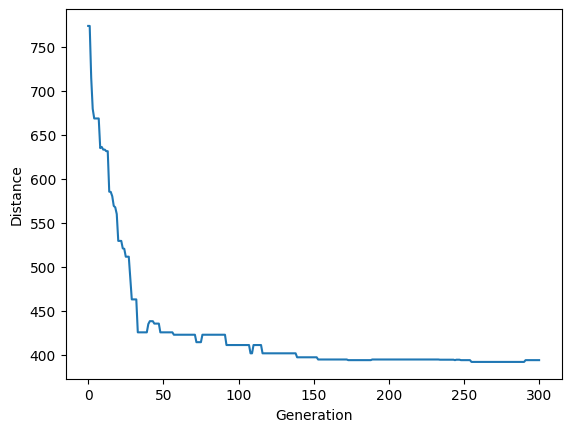

In [507]:
# Execute the GA algorithm
GeneticAlgorithm(population=nodeList, 
                 popSize=100, 
                 eliteSize=20, 
                 crossoverProb=0.99, 
                 mutationProb=0.01, 
                 generations=300)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 1</b></font>.- 
#### Analize the behaviour of the algorithm reducing the size of the chromosome (ChromosomeSize parameter)

-----------------------------------------------------------------------------------------------------

The algorithm converges faster and reduced distance when the size of the chromosomes is reduced. It is due to the fact that the number of nodes depend on the number of chromosomes. As the number of nodes decrease, the distance decreases and the algoritm converges faster.

In [526]:
# Number of nodes of a chromosome (individual or route)
ChromosomeSize =  10   

# Generate the list of nodes randomly
nodeList = {}

for i in range(0,ChromosomeSize):
    n = dict(x=random.random()*100,
             y=random.random()*100)
    nodeList[i]=n

Initial path distance:  24.0
Initial path: [0, 9, 8, 5, 6, 7, 4, 3, 1, 2]

Final path distance:  18.0
Final path: [8, 9, 7, 6, 5, 4, 0, 1, 2, 3]


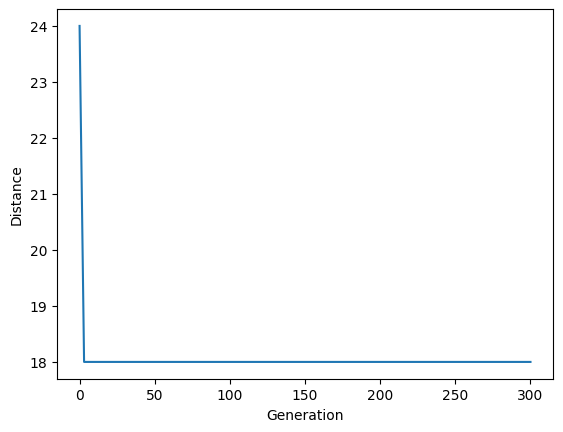

In [527]:
GeneticAlgorithm(population=nodeList, 
                 popSize=100, 
                 eliteSize=20, 
                 crossoverProb=0.99, 
                 mutationProb=0.01, 
                 generations=300)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 2</b></font>.- 
#### Analize the behaviour of the algorithm reducing and increasing the size of the elite set of individuals

-----------------------------------------------------------------------------------------------------

If the number of elite individuals is increased, the algorithm converges in early generations (faster) but when this set is reduced, it takes more generation to solve the problem and it might not give the best result at all within the generation limit.

In [510]:
# Number of nodes of a chromosome (individual or route)
ChromosomeSize =  20   

# Generate the list of nodes randomly
nodeList = {}

for i in range(0,ChromosomeSize):
    n = dict(x=random.random()*100,
             y=random.random()*100)
    nodeList[i]=n

Initial path distance:  849.2474535877119
Initial path: [6, 19, 5, 13, 10, 2, 15, 14, 11, 16, 12, 8, 1, 4, 17, 7, 0, 18, 3, 9]

Final path distance:  442.38819303804337
Final path: [3, 16, 14, 15, 5, 0, 9, 18, 11, 13, 2, 7, 19, 10, 17, 1, 4, 12, 8, 6]


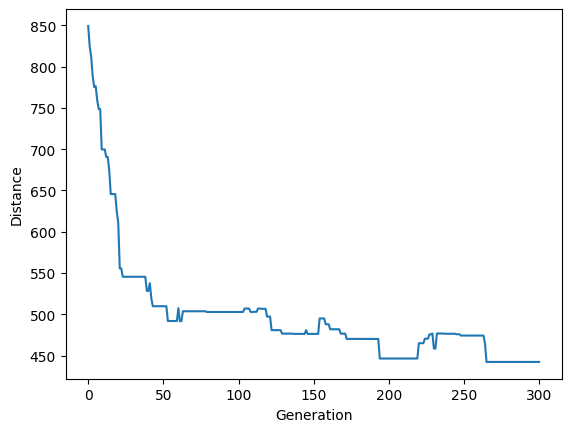

In [511]:
GeneticAlgorithm(population=nodeList, 
                 popSize=100, 
                 eliteSize=5, 
                 crossoverProb=0.99, 
                 mutationProb=0.01, 
                 generations=300)

Initial path distance:  809.0371654073899
Initial path: [5, 18, 1, 13, 19, 0, 3, 14, 15, 16, 12, 8, 17, 6, 11, 2, 7, 10, 4, 9]

Final path distance:  446.3222541005601
Final path: [10, 2, 13, 7, 19, 6, 3, 18, 11, 0, 5, 9, 15, 14, 16, 8, 12, 4, 1, 17]


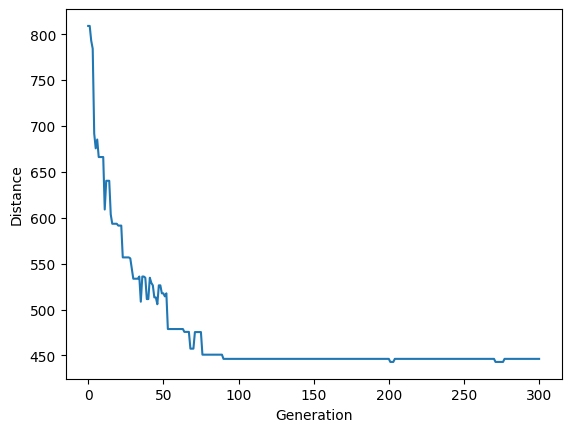

In [512]:
GeneticAlgorithm(population=nodeList, 
                 popSize=100, 
                 eliteSize=35, 
                 crossoverProb=0.99, 
                 mutationProb=0.01, 
                 generations=300)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 3</b></font>.- 
#### Analize the behaviour of the algorithm increasing the probability of mutation (to 0.8 or 0.9, for instance)

-----------------------------------------------------------------------------------------------------

When the mutation probability is increased a lot, the algorithm does not reach the optimum solution. It mutates every other chromosome and randomly tries to slve the problem. It is similar to using new chromosomes in every part, rather taking the best ones.

Initial path distance:  827.8015700011056
Initial path: [17, 10, 2, 13, 0, 9, 11, 3, 19, 7, 16, 6, 18, 15, 12, 5, 8, 4, 1, 14]

Final path distance:  793.8506051638827
Final path: [6, 19, 1, 4, 12, 8, 14, 13, 16, 17, 7, 10, 15, 18, 9, 5, 0, 3, 2, 11]


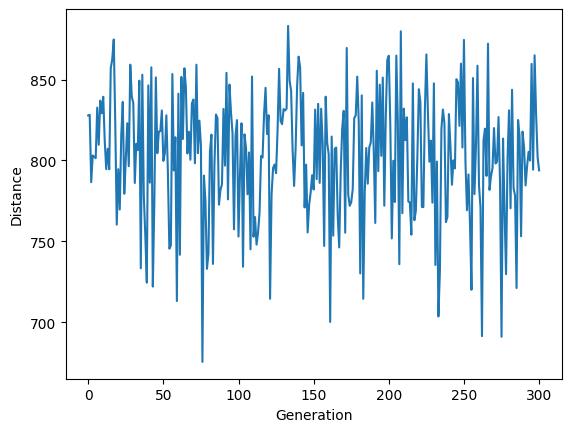

In [513]:
GeneticAlgorithm(population=nodeList, 
                 popSize=100, 
                 eliteSize=20, 
                 crossoverProb=0.99, 
                 mutationProb=0.8, 
                 generations=300)

## <font color=green><b>ANT COLONY OPTIMIZATION ALGORITHMS</b></font>

The<b> <font color=blue>Ant Colony Optimization (ACO) algorithm</font></b>  is one of the most successful strands of swarm intelligence. The goal of swarm intelligence is the design of intelligent multi-agent systems by taking inspiration from the collective behavior of social insects such as ants, termites, bees, wasps, and other animal societies such as flocks of birds or fish schools.

The most interesting aspect of the collaborative behavior of several ant species is their ability to find the shortest paths between the ants' nest and the food sources by tracing pheromone trails. Then, ants choose the path to follow by a probabilistic decision biased by the amount of pheromone: the stronger the pheromone trail, the higher its desirability. Because ants deposit pheromones on their path, this behavior results in a self-reinforcing process leading to the formation of paths marked by high pheromone concentration. 

In this case, we will apply ACO to find a solution to the <b><font color=blue>traveling salesman problem (TSP)</font></b>.

In this algorithm, a pheromone strength is associated with each arc, which is numerical information that will be modified during the algorithm's run. Initially, each of the $m$ ants is placed on a randomly chosen node and then iteratively applies a state transition rule at each node. An ant constructs a tour as follows. At node i, the ant chooses a still unvisited node j probabilistically biased by the pheromone trail strength on the arc between node i and node j and the arc length. After all ants have constructed a tour, the pheromones are updated. 
The trail update is done in such a form that arcs contained in shorter tours and/or visited by many ants receive a higher amount of pheromone and are therefore chosen with a higher probability in the following iterations of the algorithm. In this sense, the amount of pheromone represents the learned desirability of choosing the next node j when an ant is at node i.

The steps are the following:

<ul> 
<li> <b><font color=blue>1</font></b>: Initially, each ant is put on some randomly chosen node. All arcs are initialized to the same pheromone value (in our case, equal to 1).
<li> <b><font color=blue>2</font></b>: At each construction step, ant $k$ applies a probabilistic action choice rule. In particular, the probability with which ant $k$, currently at node i, chooses to go to node j at the $t_{th}$ iteration of the algorithm is:
\begin{align}
p_{ij}^k(t) = \frac{\tau_{ij}^\alpha(t)\cdot1/d_{ij}^\beta}{\sum_{l\in N_i^k}\tau_{il}^\alpha(t)\cdot1/d_{il}^\beta}
\end{align}
where $d_{ij}$ is the distance between nodes $i$ and $j$, $\tau_{ij}$ is the pheromone value in the arc between these two nodes, $\alpha$ and $\beta$ are two parameters that determine the relative influence of the pheromone trail and the node distance information, and $N_i^k$ is the feasible neighborhood of and $k$ (i.e., nodes which ant $k$ has not yet visited. If $\alpha = 0$, the closest nodes are more likely to be
selected. On the contrary $\beta=0$, only pheromone amplification is at work. With these two parameters,  there is a trade-off between using the arc length information or the pheromone intensity to decide the next hop.
<li> <b><font color=blue>3</font></b>: After each ant completes its tour, the pheromone amount on each arc will be adjusted according to the equation:
\begin{align}
\tau_{ij}(t+1) = (1-\rho)\cdot\tau_{ij}(t) + \sum_{k=1, \ldots,m}\frac{Q}{L_k}
\end{align}    
where $\rho$ is the pheromone trail evaporation, $L_k$ is the length of the path followed by ant $k$, and $Q$ is an arbitrary constant.   


The algorithm stops after a given number of iterations.

In [514]:
import numpy as np
import random
import matplotlib.pyplot as plt

## <font color=purple>Python functions</font>

In [546]:
""" Initialize pheromones and best path""" 

def Init(nodes):
    
    n_nodes = len(nodes)
    pheromone = np.ones((n_nodes, n_nodes))
    best_path = None
    best_path_length = np.inf
    
    return n_nodes, pheromone, best_path, best_path_length
    

In [547]:
""" Initialize current node, visited nodes and path of one ant """ 

def InitAnt(n_nodes):
    
    visited = [False]*n_nodes
    current_node = np.random.randint(n_nodes)
    visited[current_node] = True
    path = [current_node]
    path_length = 0
    
    return current_node, visited, path, path_length

In [548]:
""" Compute the distance between two points """ 

def Distance(node1, node2):

    return np.sqrt(np.sum((node1 - node2)**2))

In [549]:
""" Compute the total distance of one path """ 

def RouteDistance(path):
    
    if path==None: return(np.inf)
    
    pathDistance = 0
    for i in range(0, len(path)):
        fromNode = path[i]
        toNode = None
        if i+1 < len(path):
            toNode = path[i+1]
        else:
            toNode = path[0]
        pathDistance += Distance(fromNode, toNode)
    
    return pathDistance

In [550]:
""" Compute probabilites with which an ant from its current_node, chooses to go to unvisited nodes """ 

def ComputeProbabilities(current_node, visited, nodes, pheromone, alpha, beta):
    
    unvisited = np.where(np.logical_not(visited))[0]
    probabilities = np.zeros(len(unvisited))

    for i, unvisited_node in enumerate(unvisited):
        d = Distance(nodes[current_node], nodes[unvisited_node])
        probabilities[i] = pheromone[current_node, unvisited_node]**alpha / d**beta

    probabilities /= np.sum(probabilities)
    
    return probabilities, unvisited

In [551]:
""" Get the next node for one ant and update its path """ 

def ComputeNextHop(current_node, visited, unvisited, nodes, probabilities, path, path_length):
    
    next_node = np.random.choice(unvisited, p=probabilities)
    path.append(next_node)
    path_length += Distance(nodes[current_node], nodes[next_node])
    visited[next_node] = True
    current_node = next_node
    
    return next_node, path, path_length

In [552]:
""" Update the set of paths of different ants, their lengths and the best path """ 

def UpdatePaths(path, path_length):
    
    global paths, paths_lengths, best_path, best_path_length
    
    paths.append(path)
    paths_lengths.append(path_length)
    
    if RouteDistance(path) < RouteDistance(best_path):
        best_path = path
        best_path_length = path_length
        

In [553]:
""" Update pheromone values. The pheromone trail on each edge is updated based on the quality
    of the solution found by the ant that traversed that edge """ 

def UpdatePheromones(path, path_length, pheromone, evaporation_rate,n_nodes, Q):
    
    global paths, paths_lengths
    
    pheromone *= (1-evaporation_rate)
    
    for path, path_length in zip(paths, paths_lengths):
        for i in range(n_nodes-1):
            pheromone[path[i], path[i+1]] += Q/path_length
        pheromone[path[-1], path[0]] += Q/path_length
        
    return pheromone

In [554]:
"""Ant Colony Optimization algorithm. Maintain the evolution of the algorithm """

def ACO_optimization(nodes, n_ants, n_iterations, alpha, beta, evaporation_rate, Q): 
    
    global paths, paths_lengths, best_path, best_path_length
    
    evolution = [] # we will mantain information of the path distance during the execution

    n_nodes, pheromone, best_path, best_path_length = Init(nodes)
    
    for iteration in range(n_iterations):
        paths = []
        paths_lengths = []
        
        for ant in range(n_ants):
            current_node, visited, path, path_length = InitAnt(n_nodes)
            
            while False in visited:
                probabilities, unvisited = \
                       ComputeProbabilities(current_node, visited, nodes, \
                                            pheromone, alpha, beta)
                
                current_node, path, path_length = \
                       ComputeNextHop(current_node, visited, unvisited, nodes, \
                                      probabilities, path, path_length)

        UpdatePaths(path, path_length)    

        pheromone = UpdatePheromones(path, path_length, pheromone, \
                                     evaporation_rate, n_nodes, Q)
    
        evolution.append(RouteDistance(best_path))
        
        if (iteration==0):
            print('Initial path:', path, 'distance:',RouteDistance(path) )

    print('Final path:', best_path, 'distance:',RouteDistance(best_path) )
    
    plt.plot(evolution)
    plt.ylabel('Distance')
    plt.xlabel('Iteration')
    plt.show()

### <font color=purple>GENERATE THE LIST OF NODES</font>

In [555]:
# Global variables
paths = []
paths_lengths = []        
best_path = None
best_path_length = np.inf

# Number of nodes
numNodes =  20

# Generate the list of nodes randomly
nodeList = np.random.rand(numNodes, 2)*100

### <font color=purple>RUN THE ACO ALGORITHM and PLOT ITS EVOLUTION</font>

Initial path: [9, 11, 16, 18, 12, 8, 6, 10, 14, 15, 4, 3, 1, 5, 7, 2, 13, 0, 19, 17] distance: 108.0
Final path: [16, 18, 10, 2, 7, 5, 1, 9, 11, 17, 19, 15, 13, 4, 3, 8, 0, 12, 6, 14] distance: 104.0


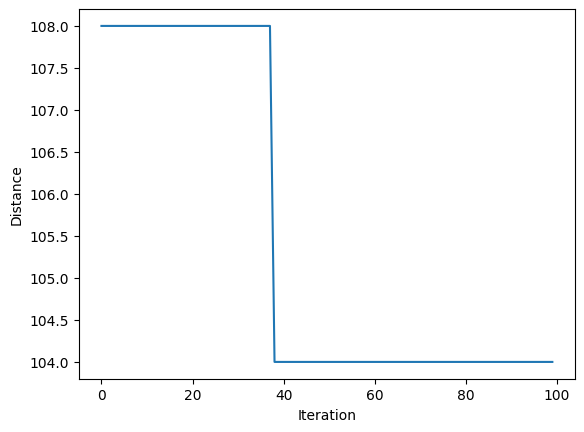

In [559]:
ACO_optimization(nodeList, 
                 n_ants=10, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=1, 
                 evaporation_rate=0.5, 
                 Q=1)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 4</b></font>.- 
#### Analize the behaviour of the algorithm if we have a few number of ants.

-----------------------------------------------------------------------------------------------------

As the number of ants decrease, the optimum path is harder to achieve. Because as the number of ants is less, less path is discovered in the same iteration and the path is not updated as much. So we are stuck with the non optimal path because more ants discover more paths in the same iteration and less ants cannot do it.

Initial path: [13, 2, 15, 6, 14, 16, 11, 9, 12, 19, 4, 0, 8, 7, 17, 1, 18, 10, 3, 5] distance: 156.0
Final path: [4, 15, 6, 13, 10, 18, 19, 12, 5, 1, 17, 16, 14, 7, 8, 9, 11, 2, 0, 3] distance: 102.0


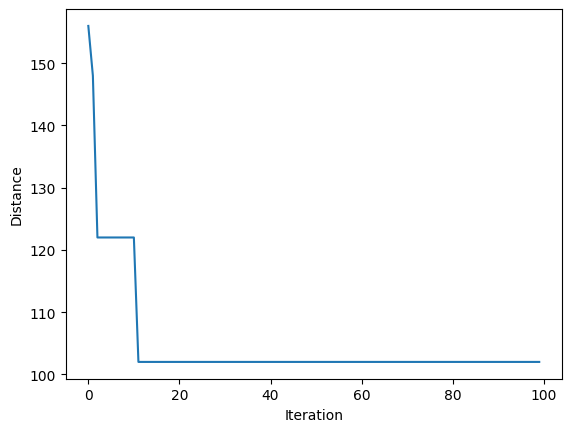

In [596]:
ACO_optimization(nodeList, 
                 n_ants=5, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=1, 
                 evaporation_rate=0.5, 
                 Q=1)

Initial path: [7, 6, 9, 11, 14, 1, 19, 4, 2, 18, 16, 0, 12, 3, 8, 13, 10, 17, 5, 15] distance: 162.0
Final path: [14, 5, 1, 18, 16, 19, 9, 2, 4, 0, 10, 12, 13, 15, 6, 3, 11, 8, 7, 17] distance: 110.0


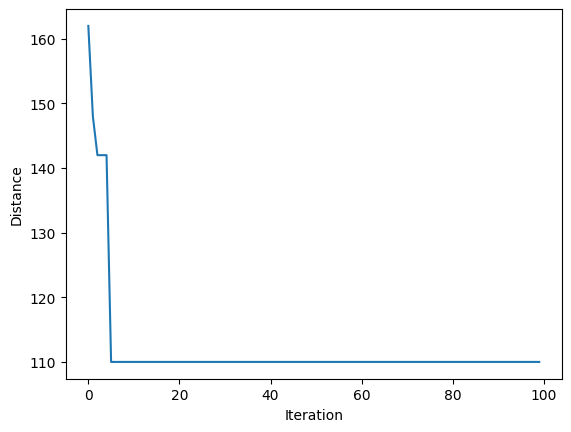

In [597]:
ACO_optimization(nodeList, 
                 n_ants=2, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=1, 
                 evaporation_rate=0.5, 
                 Q=1)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 5</b></font>.- 
#### Analize the behaviour of the algorithm reducing the pheromone decay factor.

-----------------------------------------------------------------------------------------------------

As the decay factor decreases, the algorithm provides better path distance. 

Initial path: [2, 8, 7, 15, 14, 6, 10, 17, 1, 9, 19, 5, 0, 12, 18, 11, 16, 3, 13, 4] distance: 152.0
Final path: [5, 17, 16, 12, 8, 1, 9, 19, 18, 10, 13, 14, 6, 15, 11, 7, 3, 4, 2, 0] distance: 98.0


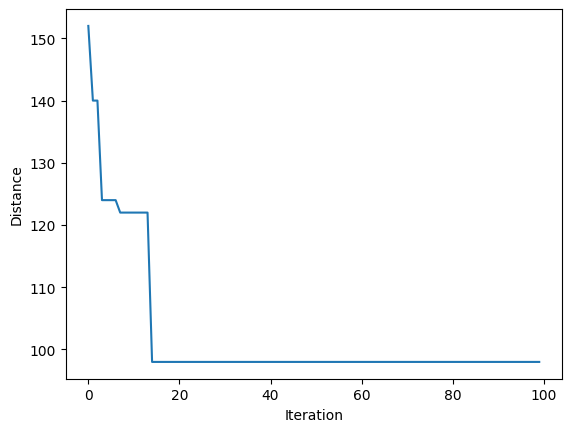

In [610]:
ACO_optimization(nodeList, 
                 n_ants=10, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=1, 
                 evaporation_rate=0.25, 
                 Q=1)

Initial path: [0, 3, 8, 7, 19, 16, 5, 17, 12, 10, 1, 6, 14, 4, 13, 2, 15, 18, 9, 11] distance: 144.0
Final path: [14, 15, 6, 4, 8, 7, 1, 3, 9, 5, 12, 19, 17, 16, 18, 10, 11, 0, 2, 13] distance: 88.0


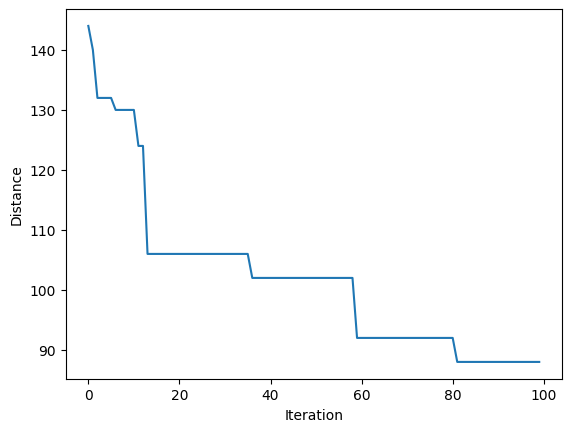

In [611]:
ACO_optimization(nodeList, 
                 n_ants=10, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=1, 
                 evaporation_rate=0.1, 
                 Q=1)

-----------------------------------------------------------------------------------------------------

### <font color=blue><b>EXERCISE 6</b></font>.- 
#### Analize the behaviour of the algorithm varying the parameters $\alpha$ and $\beta$.

-----------------------------------------------------------------------------------------------------

If we increase alpha, the algorithm remembers more of the previous path, so we might not always get the best path.
If we increase beta, it gives more importance to the distance factor. So, we get the better distance of the path if we increse beta and vice versa.

Initial path: [2, 6, 14, 15, 9, 1, 19, 11, 16, 18, 8, 7, 17, 13, 10, 0, 12, 3, 5, 4] distance: 124.0
Final path: [2, 18, 10, 11, 16, 7, 12, 0, 19, 17, 9, 1, 4, 3, 6, 15, 14, 13, 8, 5] distance: 122.0


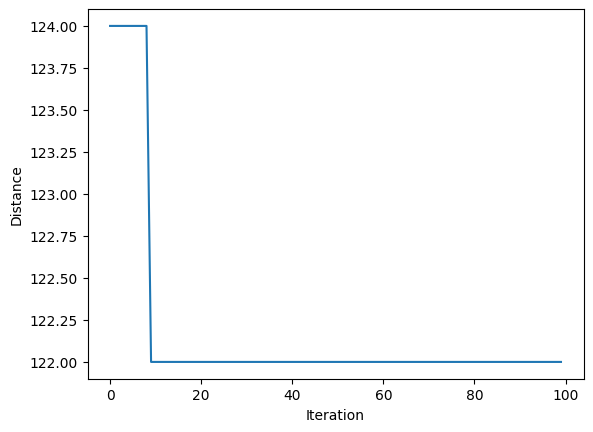

In [606]:
ACO_optimization(nodeList, 
                 n_ants=10, 
                 n_iterations=100, 
                 alpha=10, 
                 beta=1, 
                 evaporation_rate=0.5, 
                 Q=1)

Initial path: [13, 2, 15, 14, 6, 10, 18, 11, 16, 17, 1, 9, 5, 19, 12, 0, 7, 8, 4, 3] distance: 142.0
Final path: [2, 13, 6, 14, 15, 18, 10, 11, 16, 19, 17, 1, 9, 5, 8, 7, 4, 3, 0, 12] distance: 110.0


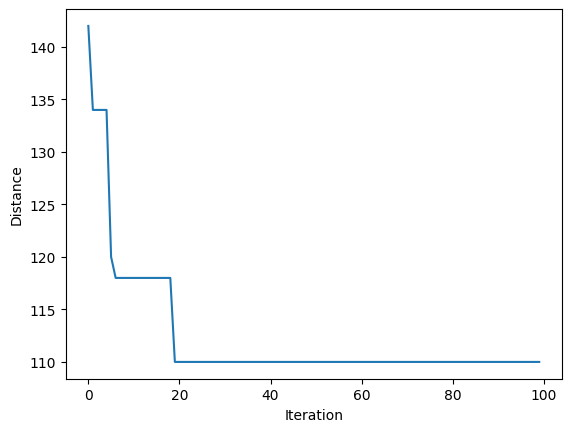

In [607]:
ACO_optimization(nodeList, 
                 n_ants=10, 
                 n_iterations=100, 
                 alpha=1, 
                 beta=10, 
                 evaporation_rate=0.5, 
                 Q=1)